# 1. Exploratory Data Analysis

Data source: AirQualityUCI.csv
DATASET OVERVIEW
Shape: (9471, 15)

Columns: ['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

Dtypes:
 Date              object
Time              object
CO(GT)           float64
PT08.S1(CO)      float64
NMHC(GT)         float64
C6H6(GT)         float64
PT08.S2(NMHC)    float64
NOx(GT)          float64
PT08.S3(NOx)     float64
NO2(GT)          float64
PT08.S4(NO2)     float64
PT08.S5(O3)      float64
T                float64
RH               float64
AH               float64
dtype: object

Temporal range: 2004-03-10 18:00:00 → 2005-04-04 14:00:00
Duration: 389 days

MISSING VALUE ANALYSIS
               Count  Percentage
NMHC(GT)        8443       90.23
CO(GT)          1683       17.99
NO2(GT)         1642       17.55
NOx(GT)         1639       17.52
PT08.S1(CO)      366        3.91
C6H6(GT)         366        3.91
PT08.S2(NMHC)    366   

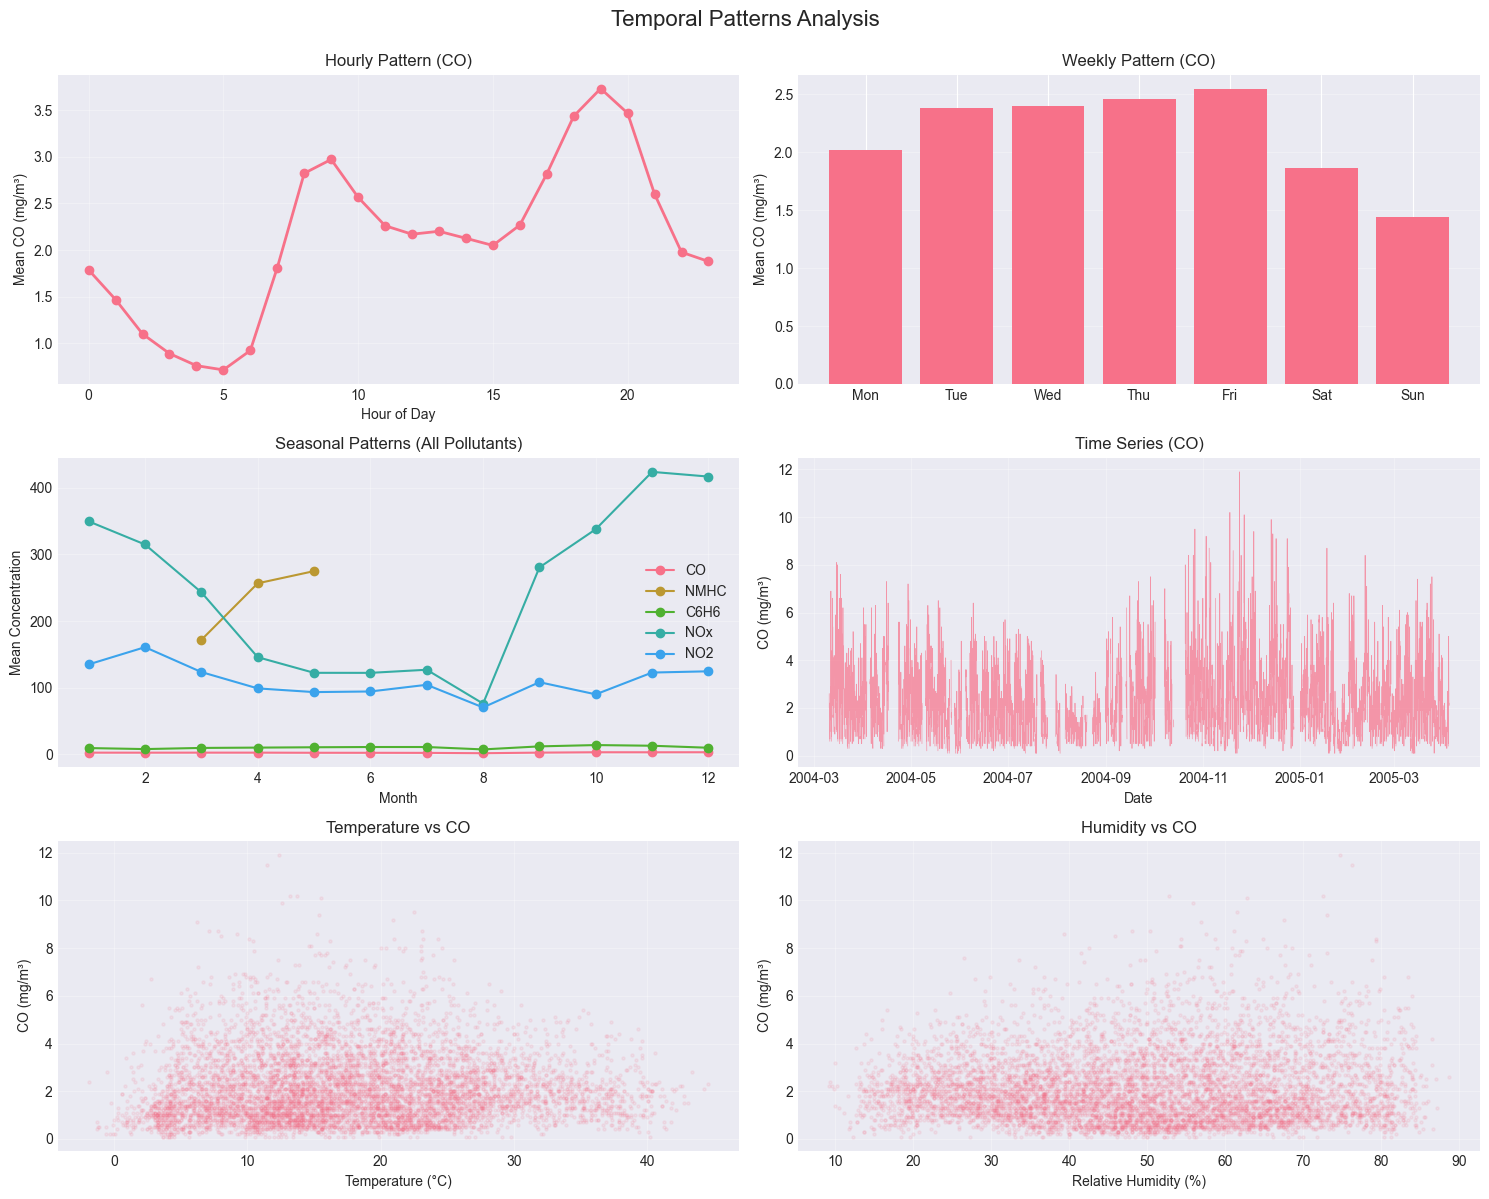

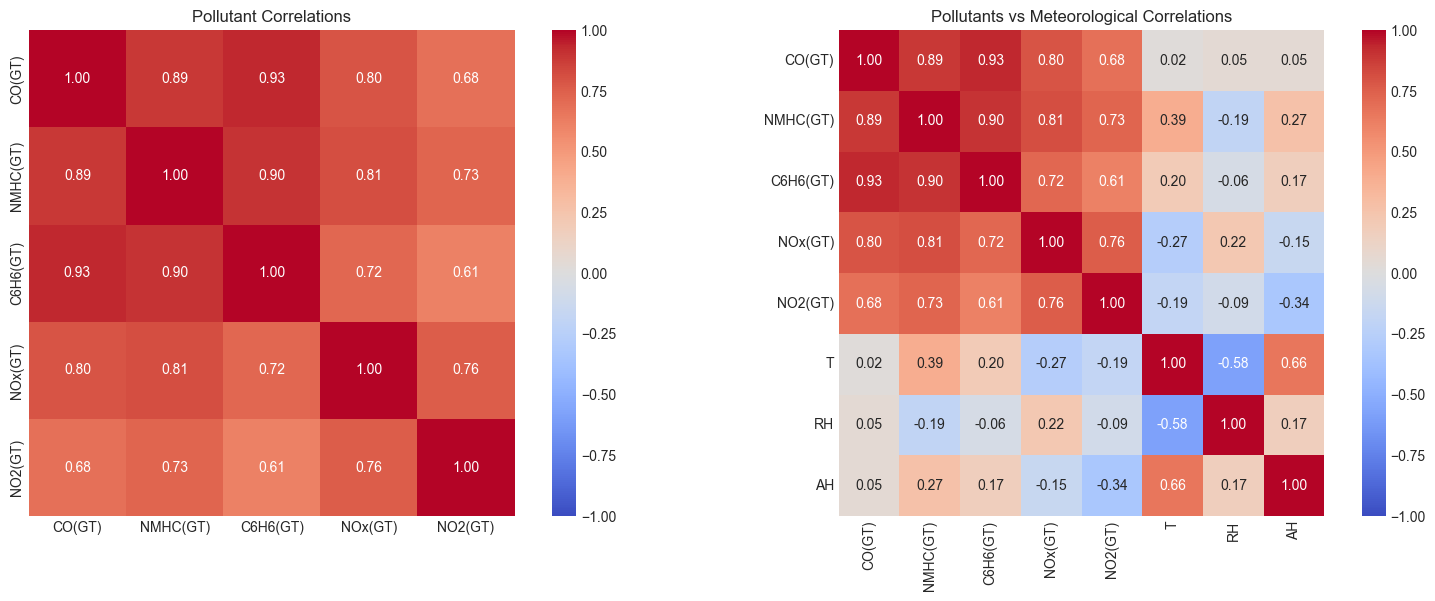

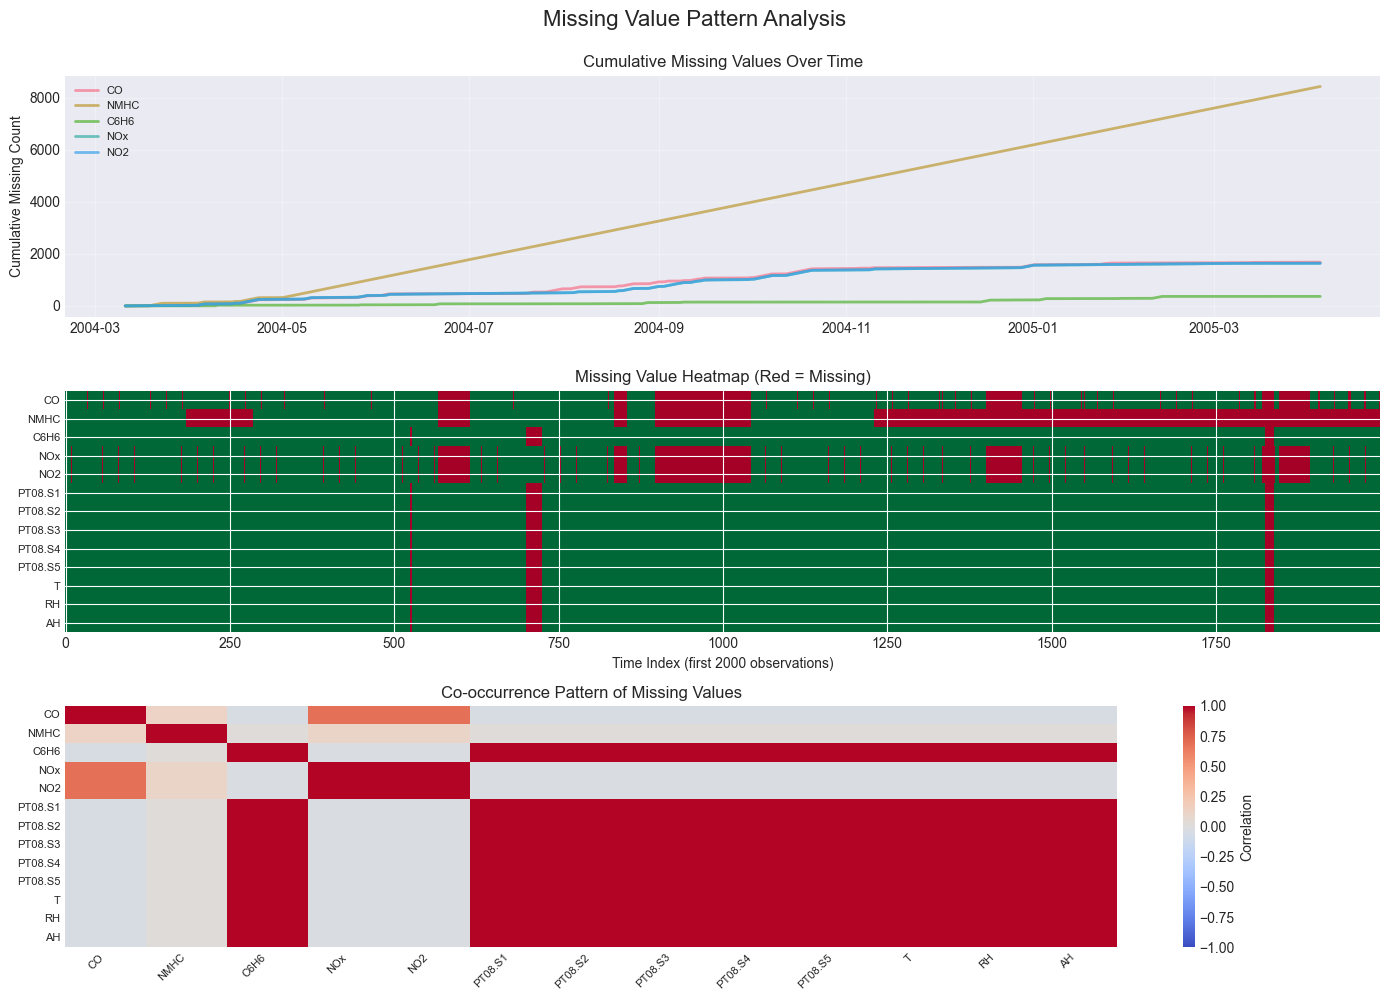

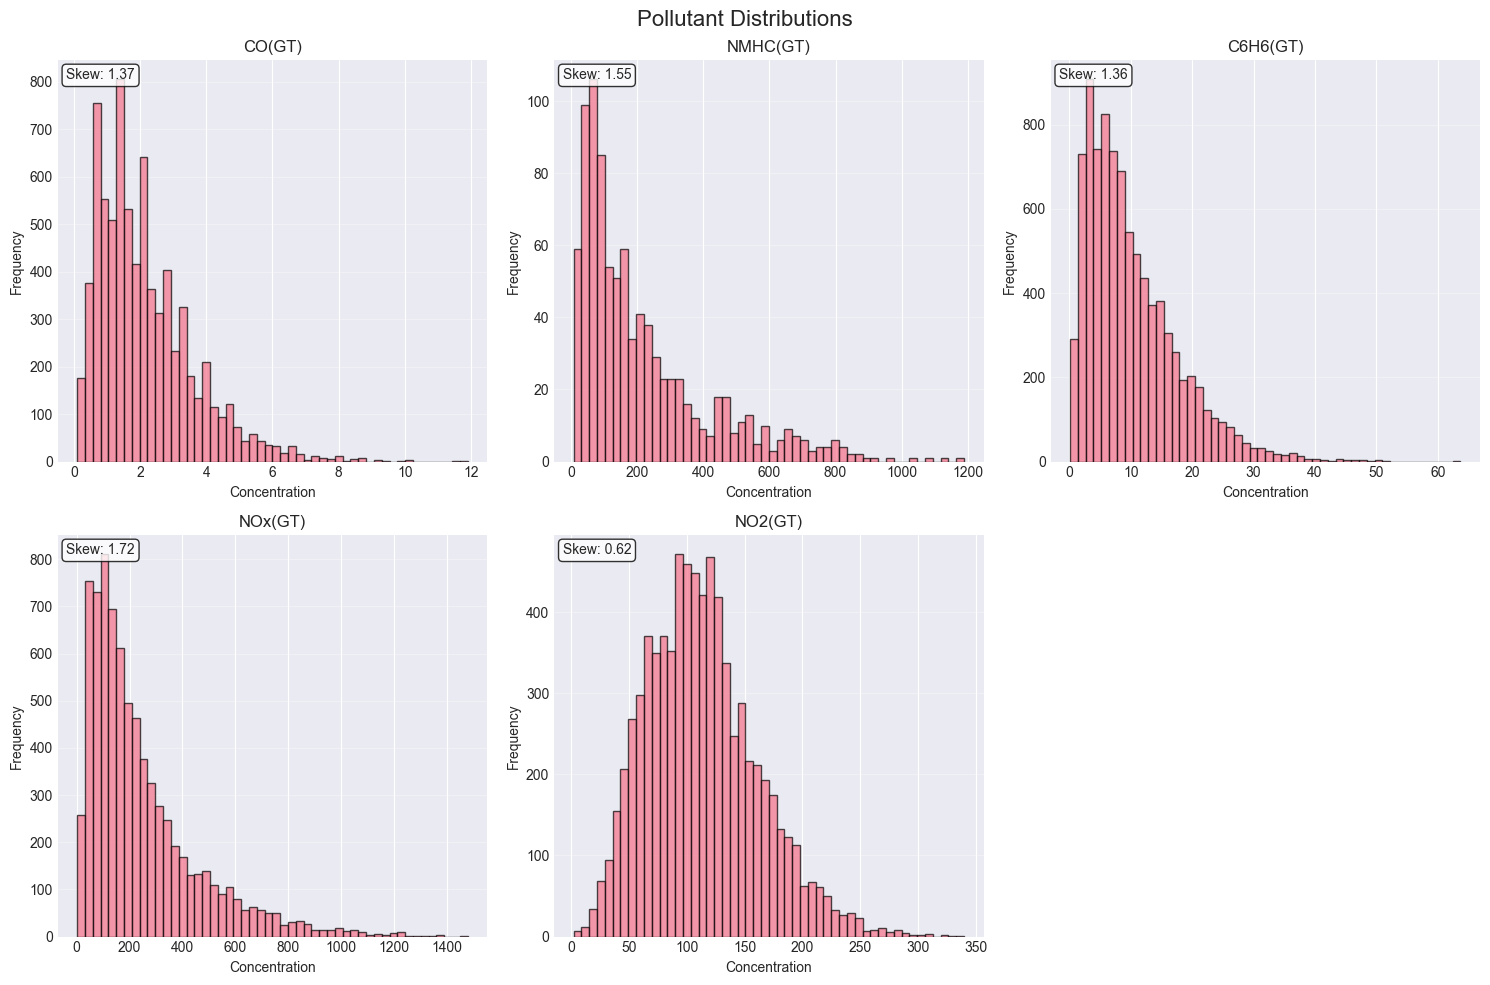

In [2]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# ------------------------------------------------------------------
# Paths and plotting configuration
# ------------------------------------------------------------------
PROJECT_ROOT = Path("..")                     # notebook/ → project root
DATA_DIR = PROJECT_ROOT / "data_orig" / "data" / "air+quality"
OUTPUT_DIR = PROJECT_ROOT / "output_EDA"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

# ------------------------------------------------------------------
# 1. Load raw data
# ------------------------------------------------------------------
try:
    df = pd.read_excel(DATA_DIR / "AirQualityUCI.xlsx")
    print("Data source: AirQualityUCI.xlsx")
except Exception:
    df = pd.read_csv(DATA_DIR / "AirQualityUCI.csv", sep=";", decimal=",")
    print("Data source: AirQualityUCI.csv")

# Remove empty/unnamed columns
df = df.loc[:, ~df.columns.str.contains(r"^Unnamed")]

print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"Shape: {df.shape}")
print("\nColumns:", df.columns.tolist())
print("\nDtypes:\n", df.dtypes)

# ------------------------------------------------------------------
# 2. Construct DateTime index and temporal features
# ------------------------------------------------------------------
df["DateTime"] = pd.to_datetime(
    df["Date"] + " " + df["Time"],
    format="%d/%m/%Y %H.%M.%S",
    errors="coerce",
)
df = df.dropna(subset=["DateTime"])
df = df.set_index("DateTime").sort_index()
df = df.drop(columns=["Date", "Time"])

df["Hour"] = df.index.hour
df["DayOfWeek"] = df.index.dayofweek
df["Month"] = df.index.month
df["Year"] = df.index.year

print(f"\nTemporal range: {df.index.min()} → {df.index.max()}")
print(f"Duration: {(df.index.max() - df.index.min()).days} days")

# ------------------------------------------------------------------
# 3. Missing-value analysis (-200 → NaN)
# ------------------------------------------------------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].replace(-200.0, np.nan)

print("\n" + "=" * 60)
print("MISSING VALUE ANALYSIS")
print("=" * 60)
missing_summary = pd.DataFrame(
    {
        "Count": df.isnull().sum(),
        "Percentage": (df.isnull().sum() / len(df) * 100).round(2),
    }
)
missing_summary = (
    missing_summary[missing_summary["Count"] > 0]
    .sort_values("Count", ascending=False)
)
print(missing_summary)

# ------------------------------------------------------------------
# 4. Summary statistics
# ------------------------------------------------------------------
pollutants = ["CO(GT)", "NMHC(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)"]
sensors = [
    "PT08.S1(CO)",
    "PT08.S2(NMHC)",
    "PT08.S3(NOx)",
    "PT08.S4(NO2)",
    "PT08.S5(O3)",
]
meteo = ["T", "RH", "AH"]
all_features = pollutants + sensors + meteo

print("\n" + "=" * 60)
print("POLLUTANT STATISTICS")
print("=" * 60)
print(df[pollutants].describe().round(3))

# ------------------------------------------------------------------
# 5. Temporal patterns (Figure: Temporal_Patterns)
# ------------------------------------------------------------------
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle("Temporal Patterns Analysis", fontsize=16, y=0.995)

# Hourly pattern
hourly_mean = df.groupby("Hour")["CO(GT)"].mean()
axes[0, 0].plot(hourly_mean.index, hourly_mean.values, marker="o", linewidth=2)
axes[0, 0].set_xlabel("Hour of Day")
axes[0, 0].set_ylabel("Mean CO (mg/m³)")
axes[0, 0].set_title("Hourly Pattern (CO)")
axes[0, 0].grid(True, alpha=0.3)

# Weekly pattern
weekly_mean = df.groupby("DayOfWeek")["CO(GT)"].mean()
days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
axes[0, 1].bar(range(7), weekly_mean.values)
axes[0, 1].set_xticks(range(7))
axes[0, 1].set_xticklabels(days)
axes[0, 1].set_ylabel("Mean CO (mg/m³)")
axes[0, 1].set_title("Weekly Pattern (CO)")
axes[0, 1].grid(True, alpha=0.3, axis="y")

# Monthly patterns for all pollutants
for pollutant in pollutants:
    monthly_mean = df.groupby("Month")[pollutant].mean()
    axes[1, 0].plot(
        monthly_mean.index,
        monthly_mean.values,
        marker="o",
        label=pollutant.split("(")[0],
    )
axes[1, 0].set_xlabel("Month")
axes[1, 0].set_ylabel("Mean Concentration")
axes[1, 0].set_title("Seasonal Patterns (All Pollutants)")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Time series
axes[1, 1].plot(df.index, df["CO(GT)"], linewidth=0.5, alpha=0.7)
axes[1, 1].set_xlabel("Date")
axes[1, 1].set_ylabel("CO (mg/m³)")
axes[1, 1].set_title("Time Series (CO)")
axes[1, 1].grid(True, alpha=0.3)

# Temperature vs CO
axes[2, 0].scatter(df["T"], df["CO(GT)"], alpha=0.1, s=5)
axes[2, 0].set_xlabel("Temperature (°C)")
axes[2, 0].set_ylabel("CO (mg/m³)")
axes[2, 0].set_title("Temperature vs CO")
axes[2, 0].grid(True, alpha=0.3)

# Humidity vs CO
axes[2, 1].scatter(df["RH"], df["CO(GT)"], alpha=0.1, s=5)
axes[2, 1].set_xlabel("Relative Humidity (%)")
axes[2, 1].set_ylabel("CO (mg/m³)")
axes[2, 1].set_title("Humidity vs CO")
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(
    OUTPUT_DIR / "Temporal_Patterns.png",
    dpi=300,
    bbox_inches="tight",
)
print(f"\n[SAVED] {OUTPUT_DIR/'Temporal_Patterns.png'}")

# ------------------------------------------------------------------
# 6. Correlation analysis (Figure: Correlation_Heatmap)
# ------------------------------------------------------------------
print("\n" + "=" * 60)
print("CORRELATION ANALYSIS")
print("=" * 60)

pollutant_corr = df[pollutants].corr()
print("\nPollutant intercorrelations:\n", pollutant_corr.round(3))

print("\nSensor–reference correlations:")
sensor_pairs = [
    ("PT08.S1(CO)", "CO(GT)"),
    ("PT08.S2(NMHC)", "NMHC(GT)"),
    ("PT08.S3(NOx)", "NOx(GT)"),
    ("PT08.S4(NO2)", "NO2(GT)"),
]
for sensor, reference in sensor_pairs:
    corr = df[[sensor, reference]].corr().iloc[0, 1]
    print(f"{sensor} ↔ {reference}: {corr:.3f}")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(
    pollutant_corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    ax=axes[0],
)
axes[0].set_title("Pollutant Correlations")

selected_features = pollutants + meteo
full_corr = df[selected_features].corr()
sns.heatmap(
    full_corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    ax=axes[1],
)
axes[1].set_title("Pollutants vs Meteorological Correlations")

plt.tight_layout()
plt.savefig(
    OUTPUT_DIR / "Correlation_Heatmap.png",
    dpi=300,
    bbox_inches="tight",
)
print(f"\n[SAVED] {OUTPUT_DIR/'Correlation_Heatmap.png'}")

# ------------------------------------------------------------------
# 7. Missing-value pattern visualisation (Figure: Missing_Pattern_Analysis)
# ------------------------------------------------------------------
print("\n" + "=" * 60)
print("MISSING PATTERN VISUALISATION")
print("=" * 60)

# Binary missing matrix and correlation of missingness
missing_matrix = df[all_features].isnull().astype(int)
missing_corr = missing_matrix.corr()

fig2, axes2 = plt.subplots(3, 1, figsize=(14, 10))
fig2.suptitle("Missing Value Pattern Analysis", fontsize=16, y=0.995)

# (1) Cumulative missing counts over time for pollutants
for feature in pollutants:
    missing_indicator = df[feature].isnull().astype(int)
    axes2[0].plot(
        df.index,
        missing_indicator.cumsum(),
        label=feature.split("(")[0],
        linewidth=2,
        alpha=0.7,
    )
axes2[0].set_ylabel("Cumulative Missing Count")
axes2[0].set_title("Cumulative Missing Values Over Time")
axes2[0].legend(loc="upper left", fontsize=8)
axes2[0].grid(True, alpha=0.3)

# (2) Heatmap of missing values (first N observations)
sample_size = min(2000, len(df))
sample_df = df[all_features].iloc[:sample_size]
missing_heatmap = sample_df.isnull().astype(int).T

im = axes2[1].imshow(
    missing_heatmap,
    cmap="RdYlGn_r",
    aspect="auto",
    interpolation="nearest",
)
axes2[1].set_yticks(range(len(all_features)))
axes2[1].set_yticklabels(
    [f.split("(")[0] for f in all_features],
    fontsize=8,
)
axes2[1].set_xlabel("Time Index (first 2000 observations)")
axes2[1].set_title("Missing Value Heatmap (Red = Missing)")

# (3) Correlation of missingness across features
sns.heatmap(
    missing_corr,
    annot=False,
    cmap="coolwarm",
    center=0,
    vmin=-1,
    vmax=1,
    ax=axes2[2],
    cbar_kws={"label": "Correlation"},
)
axes2[2].set_title("Co-occurrence Pattern of Missing Values")
axes2[2].set_xticklabels(
    [f.split("(")[0] for f in all_features],
    rotation=45,
    ha="right",
    fontsize=8,
)
axes2[2].set_yticklabels(
    [f.split("(")[0] for f in all_features],
    rotation=0,
    fontsize=8,
)

plt.tight_layout()
plt.savefig(
    OUTPUT_DIR / "Missing_Pattern_Analysis.png",
    dpi=300,
    bbox_inches="tight",
)
print(f"\n[SAVED] {OUTPUT_DIR/'Missing_Pattern_Analysis.png'}")

# ------------------------------------------------------------------
# 8. Pollutant distributions (Figure: Pollutant_Distribution)
# ------------------------------------------------------------------
fig3, axes3 = plt.subplots(2, 3, figsize=(15, 10))
fig3.suptitle("Pollutant Distributions", fontsize=16)

for idx, pollutant in enumerate(pollutants):
    row, col = divmod(idx, 3)
    data = df[pollutant].dropna()

    axes3[row, col].hist(data, bins=50, edgecolor="black", alpha=0.7)
    axes3[row, col].set_xlabel("Concentration")
    axes3[row, col].set_ylabel("Frequency")
    axes3[row, col].set_title(pollutant)
    axes3[row, col].grid(True, alpha=0.3, axis="y")

    skewness = stats.skew(data)
    axes3[row, col].text(
        0.02,
        0.98,
        f"Skew: {skewness:.2f}",
        transform=axes3[row, col].transAxes,
        va="top",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
    )

axes3[1, 2].axis("off")

plt.tight_layout()
plt.savefig(
    OUTPUT_DIR / "Pollutant_Distribution.png",
    dpi=300,
    bbox_inches="tight",
)
print(f"\n[SAVED] {OUTPUT_DIR/'Pollutant_Distribution.png'}")

# ------------------------------------------------------------------
# 9. Additional data-quality summaries (console only)
# ------------------------------------------------------------------
print("\n" + "=" * 60)
print("DATA QUALITY SUMMARY")
print("=" * 60)

print("\nOutliers (IQR method):")
for pollutant in pollutants:
    data = df[pollutant].dropna()
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).sum()
    outlier_pct = outliers / len(data) * 100
    print(f"{pollutant}: {outliers} ({outlier_pct:.2f}%)")

df["IsWeekend"] = df["DayOfWeek"].isin([5, 6]).astype(int)
print("\n" + "=" * 60)
print("WEEKDAY VS WEEKEND (CO)")
print("=" * 60)
weekend_stats = df.groupby("IsWeekend")["CO(GT)"].agg(["mean", "median", "std"])
weekend_stats.index = ["Weekday", "Weekend"]
print(weekend_stats.round(3))

print("\nEDA COMPLETE")
print("Figures saved in:", OUTPUT_DIR)
print("Generated:")
print("  - Temporal_Patterns.png")
print("  - Correlation_Heatmap.png")
print("  - Missing_Pattern_Analysis.png")
print("  - Pollutant_Distribution.png")